### DATASET

In [1]:
#!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [2]:
#!unzip cats_and_dogs_filtered.zip

In [3]:
#!rm -rf cats_and_dogs_filtered.zip

In [4]:
#!pip install tensorflow

In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 1000
Train Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


In [7]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['cat', 'dog']

In [8]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


In [9]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = (image_width, image_height),
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


In [10]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 26
Test Dataset Cardinality: 6


In [11]:
autotune = tf.data.AUTOTUNE

dataset_train = dataset_train.prefetch(buffer_size = autotune)
dataset_validation = dataset_validation.prefetch(buffer_size = autotune)
dataset_test = dataset_validation.prefetch(buffer_size = autotune)

In [12]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

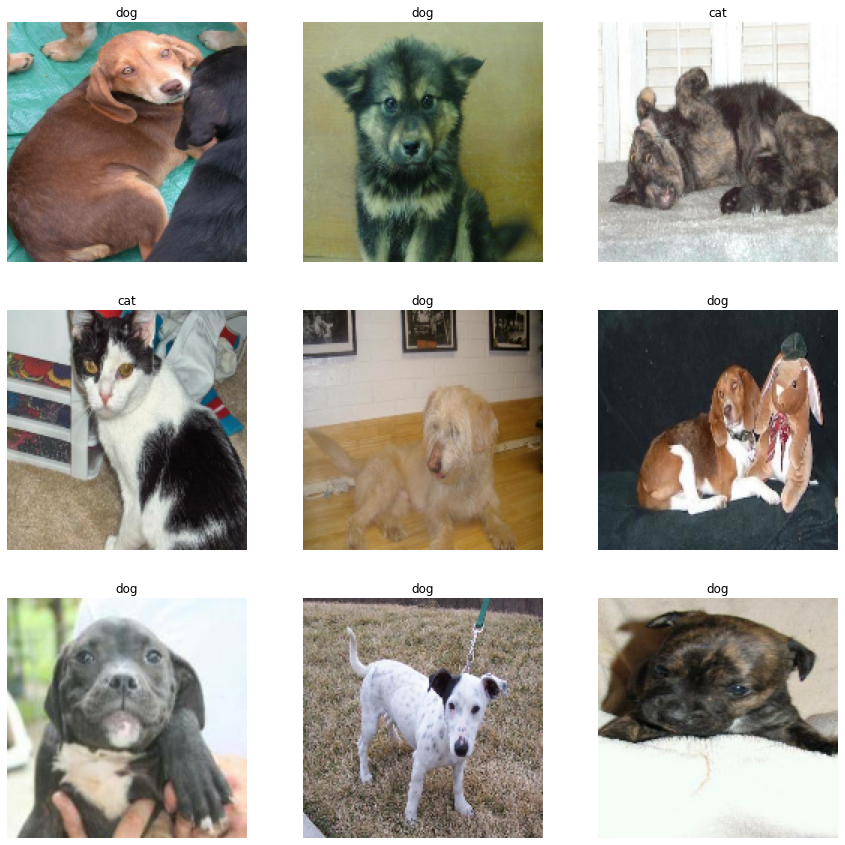

In [13]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

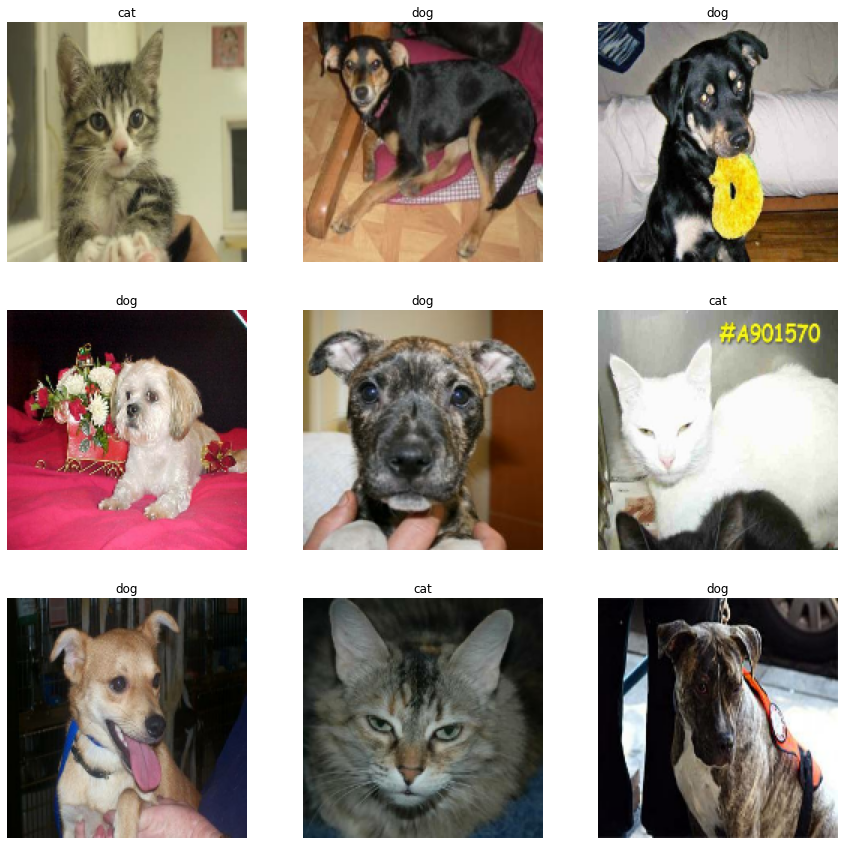

In [14]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

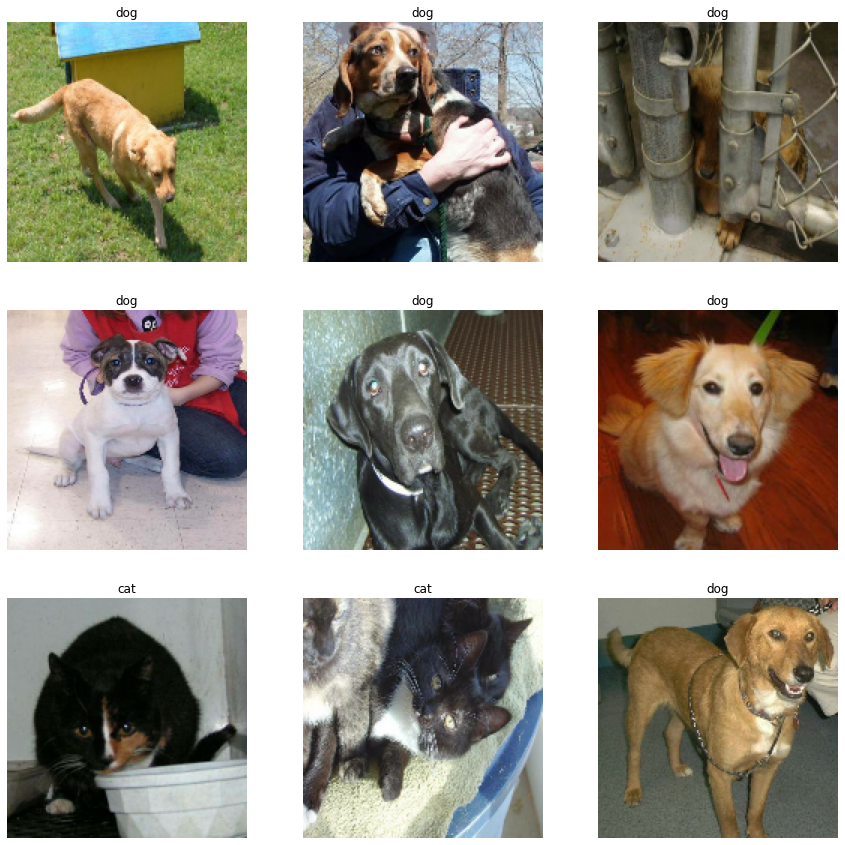

In [15]:
plot_dataset(dataset_test)

### DATA AUGMENTATION

In [16]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [17]:
def plot_dataset_data_augmentation(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, _ in dataset.take(1):

        feature = features[0]

        for i in range(9):

            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

<Figure size 432x288 with 0 Axes>

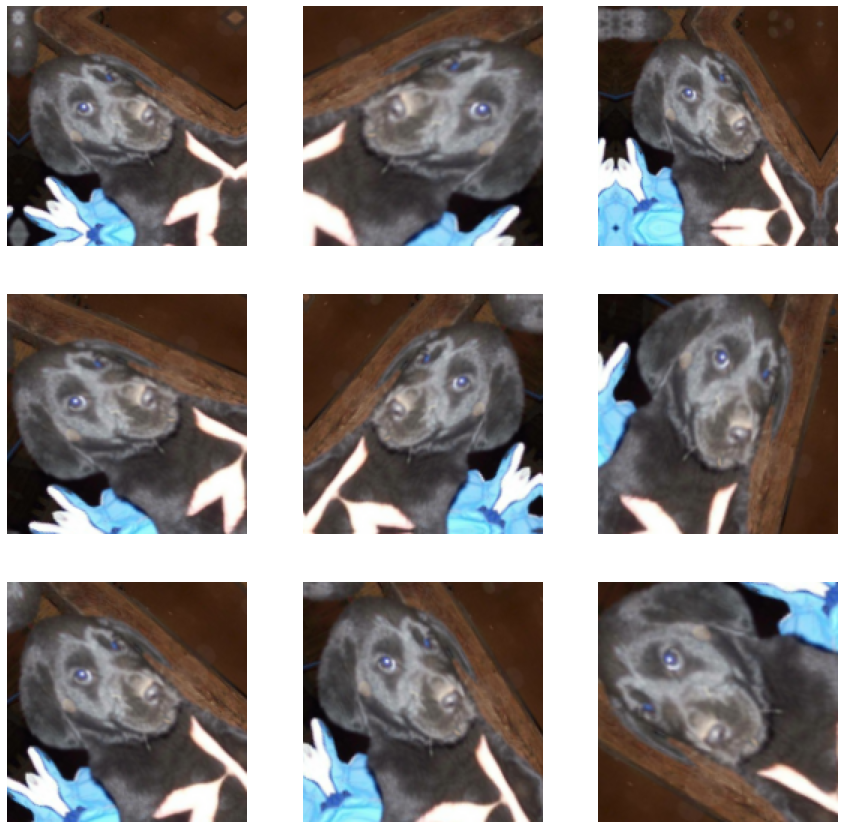

In [18]:
plot_dataset_data_augmentation(dataset_train)

### LAYER RESCALING

In [19]:
rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1. / (image_color_channel_size / 2.), offset = -1, input_shape = image_shape)

### TRANSFER LEARNING

In [20]:
model_transfer_learning = tf.keras.applications.MobileNetV2(input_shape = image_shape, include_top = False, weights = 'imagenet')
model_transfer_learning.trainable = False

model_transfer_learning.summary()

9406464/9406464 [==============================] - 3s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 20, 20, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
          

                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malizatio

 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_

 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_

### EARLY STOPPING

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

### MODEL

In [22]:
model = tf.keras.models.Sequential([
    rescaling,
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [23]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs,
    callbacks = [
        early_stopping
    ]
)

Epoch 1/20
63/63 [==============================] - 44s 637ms/step - loss: 0.7646 - accuracy: 0.5575 - val_loss: 0.5219 - val_accuracy: 0.7735
Epoch 2/20
63/63 [==============================] - 39s 618ms/step - loss: 0.5627 - accuracy: 0.7185 - val_loss: 0.3839 - val_accuracy: 0.8812
Epoch 3/20
63/63 [==============================] - 37s 576ms/step - loss: 0.4548 - accuracy: 0.8080 - val_loss: 0.3095 - val_accuracy: 0.9183
Epoch 4/20
63/63 [==============================] - 36s 569ms/step - loss: 0.3913 - accuracy: 0.8380 - val_loss: 0.2544 - val_accuracy: 0.9356
Epoch 5/20
63/63 [==============================] - 36s 576ms/step - loss: 0.3432 - accuracy: 0.8670 - val_loss: 0.2163 - val_accuracy: 0.9468
Epoch 6/20
63/63 [==============================] - 36s 568ms/step - loss: 0.3051 - accuracy: 0.8890 - val_loss: 0.1901 - val_accuracy: 0.9517
Epoch 7/20
63/63 [==============================] - 36s 576ms/step - loss: 0.2942 - accuracy: 0.8850 - val_loss: 0.1707 - val_accuracy: 0.9542

In [24]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

<Figure size 432x288 with 0 Axes>

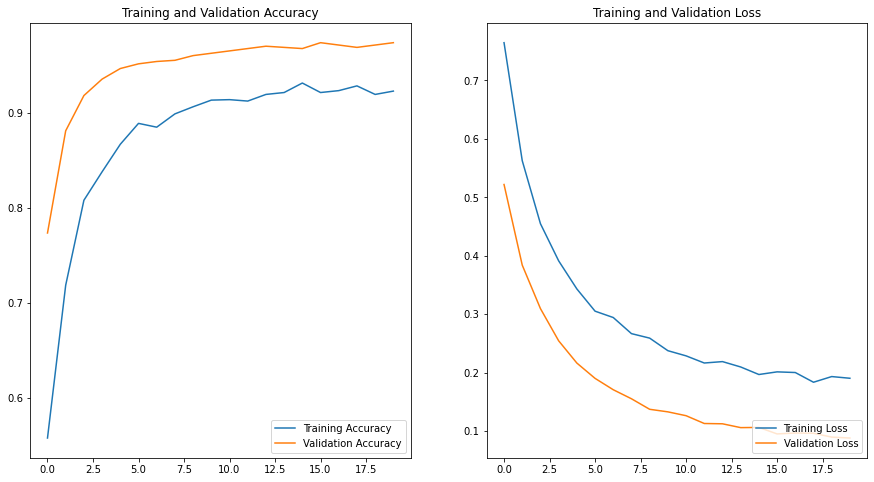

In [25]:
plot_model()

### MODEL EVALUATION

In [26]:
dataset_test_loss, dataset_test_accuracy = model.evaluate(dataset_test)

print('Dataset Test Loss:     %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

26/26 [==============================] - 9s 335ms/step - loss: 0.0892 - accuracy: 0.9740
Dataset Test Loss:     0.08922767639160156
Dataset Test Accuracy: 0.9740098714828491


In [38]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels:      [1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0]
Predictions: [1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0]


<Figure size 432x288 with 0 Axes>

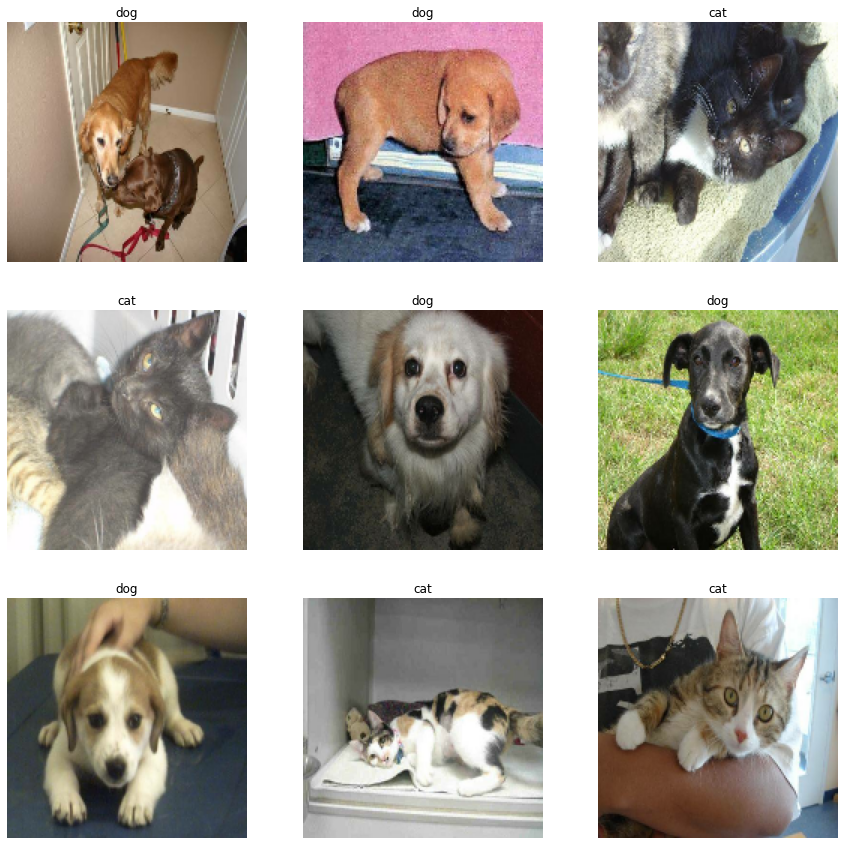

In [39]:
plot_dataset_predictions(dataset_test)

### SAVE & LOAD

In [29]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [30]:
model = tf.keras.models.load_model('model')

### PREDICTIONS

In [51]:
def predict(image_file):

    image = tf.keras.preprocessing.image.load_img(image_file, target_size = image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)

    prediction = model.predict(image)[0][0]

    print('Prediction: {0} | {1}'.format(prediction, ('cat' if prediction < 0.5 else 'dog')))

In [57]:
def predict_url(image_fname, image_origin):

    image_file = tf.keras.utils.get_file(image_fname, origin = image_origin)
    return predict(image_file)

In [58]:
predict('WhatsApp Image 2022-07-10 at 11.09.38.jpeg')

1/1 [==============================] - 0s 34ms/step
Prediction: 0.047766637057065964 | cat


In [60]:
predict_url('cat_test','https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg')

1/1 [==============================] - 0s 40ms/step
Prediction: 0.009165715426206589 | cat
